# Получение координат ключевых точек рук

В данном ноутбуке фотографии рук обрабатываются с помощью Mediapipe Hands, чтобы получить по ним ключевые точки. В итоге изклекаются x, y, z координаты для 21 ключевой точки руки (они перечислены далее). В итоге получается 63 новых признака для обучения.

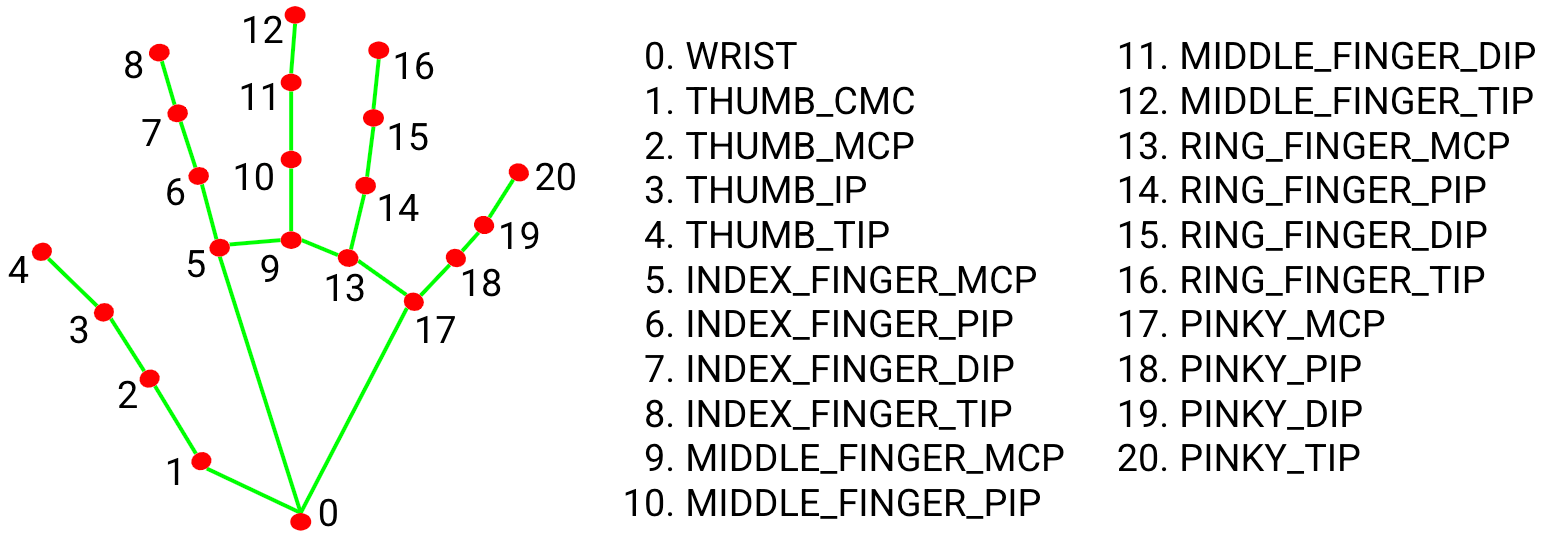

In [1]:
# установка бибилиотек
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [8]:
import numpy as np
import pandas as pd
import glob
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import keras
import csv
import mediapipe as mp
import cv2 as cv
import numpy as np
import os
import csv

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
def extract_feature(input_image):
    """
    Extracts normalized hand landmarks from an input image using MediaPipe.

    Parameters:
    input_image (str): Path to the input image.

    Returns:
    list: A list of 63 elements representing the normalized (x, y, z) coordinates
          of the 21 hand landmarks relative to the first landmark.
          If no hand is detected, returns a list of 63 zeros.
    """

    mp_hands = mp.solutions.hands
    image = cv.imread(input_image)
    image_height, image_width = image.shape[:2]
    default_landmarks = [0] * 63  # 21 landmarks * 3 coordinates (x, y, z)

    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.1) as hands:
        results = hands.process(cv.flip(cv.cvtColor(image, cv.COLOR_BGR2RGB), 1))

        if not results.multi_hand_landmarks:
            print(f"{input_image} Hand does not have landmarks")
            return default_landmarks

        annotated_image = cv.flip(image.copy(), 1)
        hand_landmarks = results.multi_hand_landmarks[0]
        first_landmark = hand_landmarks.landmark[0]
        first_landmark_x, first_landmark_y, first_landmark_z = first_landmark.x, first_landmark.y, first_landmark.z

        normalized_landmarks = []
        for landmark in hand_landmarks.landmark:
            normalized_landmarks.extend([
                landmark.x - first_landmark_x,
                landmark.y - first_landmark_y,
                landmark.z - first_landmark_z
            ])

        return normalized_landmarks

# Пример использования
input_image = "путь_до_картинки"
landmarks = extract_feature(input_image)
print("Landmarks:", landmarks)
print(len(landmarks))

Landmarks: [0.0, 0.0, 0.0, -0.11624759435653687, -0.012704253196716309, -0.10713207095875532, -0.23607629537582397, -0.06577658653259277, -0.1640662711860159, -0.27184367179870605, -0.14677682518959045, -0.21048146605505735, -0.21319764852523804, -0.21200409531593323, -0.23425035297884733, -0.2672184407711029, -0.16682428121566772, -0.05372871577753813, -0.3007526993751526, -0.1831277310848236, -0.14605279386057646, -0.25158795714378357, -0.13032987713813782, -0.16489507377161772, -0.22683930397033691, -0.12897959351539612, -0.16392697513117582, -0.1784420609474182, -0.18634480237960815, -0.03255533918752462, -0.17629474401474, -0.18993213772773743, -0.1280581963063696, -0.13892552256584167, -0.10534778237342834, -0.11462970197214872, -0.1486148238182068, -0.12415748834609985, -0.07855137556805403, -0.08223795890808105, -0.19041717052459717, -0.03392877921476156, -0.06283867359161377, -0.18023502826690674, -0.13907051205649168, -0.05523669719696045, -0.10453426837921143, -0.10789294660

In [28]:
def toCSV(filecsv, class_type, *landmarks):
    """
    Writes hand landmark data to a CSV file, appending if the file exists,
    otherwise creating a new file with headers.

    Parameters:
    filecsv (str): The path to the CSV file.
    class_type (str): The class type label for the data.
    *landmarks (float): The hand landmark data (63 values: 21 landmarks * 3 coordinates).
    """
    headers = ["class_type",
               "wristX", "wristY", "wristZ",
               "thumb_CmcX", "thumb_CmcY", "thumb_CmcZ",
               "thumb_McpX", "thumb_McpY", "thumb_McpZ",
               "thumb_IpX", "thumb_IpY", "thumb_IpZ",
               "thumb_TipX", "thumb_TipY", "thumb_TipZ",
               "index_McpX", "index_McpY", "index_McpZ",
               "index_PipX", "index_PipY", "index_PipZ",
               "index_DipX", "index_DipY", "index_DipZ",
               "index_TipX", "index_TipY", "index_TipZ",
               "middle_McpX", "middle_McpY", "middle_McpZ",
               "middle_PipX", "middle_PipY", "middle_PipZ",
               "middle_DipX", "middle_DipY", "middle_DipZ",
               "middle_TipX", "middle_TipY", "middle_TipZ",
               "ring_McpX", "ring_McpY", "ring_McpZ",
               "ring_PipX", "ring_PipY", "ring_PipZ",
               "ring_DipX", "ring_DipY", "ring_DipZ",
               "ring_TipX", "ring_TipY", "ring_TipZ",
               "pinky_McpX", "pinky_McpY", "pinky_McpZ",
               "pinky_PipX", "pinky_PipY", "pinky_PipZ",
               "pinky_DipX", "pinky_DipY", "pinky_DipZ",
               "pinky_TipX", "pinky_TipY", "pinky_TipZ"]

    file_exists = os.path.isfile(filecsv)

    with open(filecsv, 'a', newline='') as file:
        writer = csv.writer(file)

        if not file_exists:
            # Write the header if the file does not exist
            writer.writerow(headers)

        # Write the class type followed by the landmark coordinates
        writer.writerow([class_type] + list(landmarks))

In [ ]:
DATA_PATH = "путь_до_пользовательских_картинок"
csv_path = "hands_SIBI_training.csv"

dactyl = ["А", "Б", "В", "Г", "Е",
          "Ж", "И", "К", "Л", "М",
          "Н", "О", "П", "Р", "С",
          "Т", "У", "Ф", "Х", "Ч",
          "Ш", "Ы", "Э", "Ю", "Я"]
X_data, y_data = [], []

for sign in dactyl:
    sign_filename = []
    for filename in os.listdir(DATA_PATH + '/' + sign):
        if filename != ".DS_Store":
            sign_filename.append(DATA_PATH + '/' + sign + "/" + filename)
            y_data.extend(sign)
    X_data.extend(sign_filename)

metadata = pd.DataFrame({
    "X_data": X_data,
    "y_data": y_data,
})

In [ ]:
train_ratio = 0.90
test_ratio = 0.10
#validation_ratio = 0.15
RANDOM_STATE = 128

x_train, x_test, y_train, y_test = train_test_split(metadata.X_data,
                                                    metadata.y_data,
                                                    test_size= 1 - train_ratio,
                                                    random_state=RANDOM_STATE,
                                                   stratify=metadata.y_data)

x_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

x_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [ ]:
for i in range(len(x_train)):
    if i % 100 == 0:
        print(f"Обработано {i} букв")
    (first_landmark_x, first_landmark_y, first_landmark_z,
    wristX, wristY, wristZ,
    thumb_CmcX, thumb_CmcY, thumb_CmcZ,
    thumb_McpX, thumb_McpY, thumb_McpZ,
    thumb_IpX, thumb_IpY, thumb_IpZ,
    thumb_TipX, thumb_TipY, thumb_TipZ,
                  index_McpX, index_McpY, index_McpZ,
                  index_PipX, index_PipY, index_PipZ,
                  index_DipX, index_DipY, index_DipZ,
                  index_TipX, index_TipY, index_TipZ,
                  middle_McpX, middle_McpY, middle_McpZ,
                  middle_PipX, middle_PipY, middle_PipZ,
                  middle_DipX, middle_DipY, middle_DipZ,
                  middle_TipX, middle_TipY, middle_TipZ,
                  ring_McpX, ring_McpY, ring_McpZ,
                  ring_PipX, ring_PipY, ring_PipZ,
                  ring_DipX, ring_DipY, ring_DipZ,
                  ring_TipX, ring_TipY, ring_TipZ,
                  pinky_McpX, pinky_McpY, pinky_McpZ,
                  pinky_PipX, pinky_PipY, pinky_PipZ,
                  pinky_DipX, pinky_DipY, pinky_DipZ,
                  pinky_TipX, pinky_TipY, pinky_TipZ,
                  annotated_image) = extract_feature(os.path.join(x_train[i]))

    if ((not first_landmark_x == 0) and (not first_landmark_y == 0)):
        toCSV(csv_path, y_train[i],
                            wristX, wristY, wristZ,
                            thumb_CmcX, thumb_CmcY, thumb_CmcZ,
                            thumb_McpX, thumb_McpY, thumb_McpZ,
                            thumb_IpX, thumb_IpY, thumb_IpZ,
                            thumb_TipX, thumb_TipY, thumb_TipZ,
                            index_McpX, index_McpY, index_McpZ,
                            index_PipX, index_PipY, index_PipZ,
                            index_DipX, index_DipY, index_DipZ,
                            index_TipX, index_TipY, index_TipZ,
                            middle_McpX, middle_McpY, middle_McpZ,
                            middle_PipX, middle_PipY, middle_PipZ,
                            middle_DipX, middle_DipY, middle_DipZ,
                            middle_TipX, middle_TipY, middle_TipZ,
                            ring_McpX, ring_McpY, ring_McpZ,
                            ring_PipX, ring_PipY, ring_PipZ,
                            ring_DipX, ring_DipY, ring_DipZ,
                            ring_TipX, ring_TipY, ring_TipZ,
                            pinky_McpX, pinky_McpY, pinky_McpZ,
                            pinky_PipX, pinky_PipY, pinky_PipZ,
                            pinky_DipX, pinky_DipY, pinky_DipZ,
                            pinky_TipX, pinky_TipY, pinky_TipZ,)

    else :
        print(f"{x_train[i]} hand does not have landmarks")
        pass


Обработано 0 букв


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


/content/drive/MyDrive/DATA_TOTAL_13_05/Ч/284383833_AgACAgIAAxkBAAITr2YhQ0SUI3mqwI5uM1LCksLwCeimAAKR1TEbpAkJSXTbk8FqY00SAQADAgADeQADNAQ.jpg hand does not have landmarks
/content/drive/MyDrive/DATA_TOTAL_13_05/М/1388722399_AgACAgIAAxkBAAISYGYcOcrxggeyWV3gJhigRsVyDk0FAAIG3TEbqwLhSL1qSlg-zq1bAQADAgADeQADNAQ.jpg hand does not have landmarks
Обработано 100 букв
/content/drive/MyDrive/DATA_TOTAL_13_05/С/5279137947_AgACAgIAAxkBAAIa0WYmW9zNMisP9jxKfFUax_d_64wfAAI12DEbPt05SZM6e2BObdFkAQADAgADeAADNAQ.jpg hand does not have landmarks
Обработано 200 букв
Обработано 300 букв
Обработано 400 букв
/content/drive/MyDrive/DATA_TOTAL_13_05/П/881416533_AgACAgIAAxkBAAIO5mYZFIr0Y4X1KcY9j3unjCvm0Bk9AAKb1DEbJgLISKMKe8n2G4JzAQADAgADeQADNAQ.jpg hand does not have landmarks
Обработано 500 букв
/content/drive/MyDrive/DATA_TOTAL_13_05/М/881416533_AgACAgIAAxkBAAIOw2YY_DHV1zbQnq--f3M0rJpUm7t3AAJ70zEbJgLISPcfm9GYBRmBAQADAgADeQADNAQ.jpg hand does not have landmarks
Обработано 600 букв
/content/drive/MyDrive/DATA_TOTAL

In [ ]:
for i in range(len(x_test)):
    if i % 100 == 0:
        print(f"Обработано {i} букв")
    (first_landmark_x, first_landmark_y, first_landmark_z,
    wristX, wristY, wristZ,
    thumb_CmcX, thumb_CmcY, thumb_CmcZ,
    thumb_McpX, thumb_McpY, thumb_McpZ,
    thumb_IpX, thumb_IpY, thumb_IpZ,
    thumb_TipX, thumb_TipY, thumb_TipZ,
                  index_McpX, index_McpY, index_McpZ,
                  index_PipX, index_PipY, index_PipZ,
                  index_DipX, index_DipY, index_DipZ,
                  index_TipX, index_TipY, index_TipZ,
                  middle_McpX, middle_McpY, middle_McpZ,
                  middle_PipX, middle_PipY, middle_PipZ,
                  middle_DipX, middle_DipY, middle_DipZ,
                  middle_TipX, middle_TipY, middle_TipZ,
                  ring_McpX, ring_McpY, ring_McpZ,
                  ring_PipX, ring_PipY, ring_PipZ,
                  ring_DipX, ring_DipY, ring_DipZ,
                  ring_TipX, ring_TipY, ring_TipZ,
                  pinky_McpX, pinky_McpY, pinky_McpZ,
                  pinky_PipX, pinky_PipY, pinky_PipZ,
                  pinky_DipX, pinky_DipY, pinky_DipZ,
                  pinky_TipX, pinky_TipY, pinky_TipZ,
                  annotated_image) = extract_feature(os.path.join(x_test[i]))

    if ((not first_landmark_x == 0) and (not first_landmark_y == 0)):
        toCSV("hands_SIBI_test.csv", y_train[i],
                            wristX, wristY, wristZ,
                            thumb_CmcX, thumb_CmcY, thumb_CmcZ,
                            thumb_McpX, thumb_McpY, thumb_McpZ,
                            thumb_IpX, thumb_IpY, thumb_IpZ,
                            thumb_TipX, thumb_TipY, thumb_TipZ,
                            index_McpX, index_McpY, index_McpZ,
                            index_PipX, index_PipY, index_PipZ,
                            index_DipX, index_DipY, index_DipZ,
                            index_TipX, index_TipY, index_TipZ,
                            middle_McpX, middle_McpY, middle_McpZ,
                            middle_PipX, middle_PipY, middle_PipZ,
                            middle_DipX, middle_DipY, middle_DipZ,
                            middle_TipX, middle_TipY, middle_TipZ,
                            ring_McpX, ring_McpY, ring_McpZ,
                            ring_PipX, ring_PipY, ring_PipZ,
                            ring_DipX, ring_DipY, ring_DipZ,
                            ring_TipX, ring_TipY, ring_TipZ,
                            pinky_McpX, pinky_McpY, pinky_McpZ,
                            pinky_PipX, pinky_PipY, pinky_PipZ,
                            pinky_DipX, pinky_DipY, pinky_DipZ,
                            pinky_TipX, pinky_TipY, pinky_TipZ,)

    else :
        print(f"{x_test[i]} hand does not have landmarks")
        pass


Обработано 0 букв


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


/content/drive/MyDrive/DATA_TOTAL_13_05/П/901911535_AgACAgIAAxkBAAIdQ2YqX9aV7g4G_6oiZd_KNY7RsRX3AAKC3DEbw4lQSf66MQ215eRhAQADAgADeQADNAQ.jpg hand does not have landmarks
Обработано 100 букв
